In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer

In [2]:
np.random.seed(42)

def generate_low_rank_data(n_samples, n_features, rank, noise_std=2):
    # Z matrix N(0,I)
    Z = np.random.normal(0, 1, size=(n_samples, rank))
    A = np.random.randn(rank, n_features)  # Transpose A to have shape (rank, n_features)

    # Beta Matrix with shape (rank,)
    beta = np.random.randn(rank)

    # θ* = Moore-Penrose inverse of A.
    theta_star = np.linalg.pinv(A).dot(beta)

    # Generate X matrix
    X = np.dot(Z, A)  # Dot product of Z and A

    # Generate epsilon from N(0,2)
    epsilon = np.random.normal(0, noise_std, size=n_samples)

    # Generate Y vector Y = X^T θ^* + epsilon
    Y = np.dot(X, theta_star) + epsilon

    return X, Y



# Function to introduce MCAR
def introduce_missingness(X, missing_rate=0.5):
    mask = np.random.rand(*X.shape) < missing_rate
    X_missing = X.copy()
    X_missing[mask] = np.nan
    return X_missing

# Function to impute missing values
def impute_values(X_missing, strategy='constant', random_range=None):
    if strategy == 'constant':
        imputer = SimpleImputer(strategy=strategy, fill_value=0)
    elif strategy == 'optimal':
        imputer = SimpleImputer(strategy='mean')
    elif strategy == 'ICE':
        imputer = IterativeImputer(max_iter=1, random_state=0)
    elif strategy == 'random':
        random_value = np.random.randint(random_range[0], random_range[1] + 1)
        X_missing[np.isnan(X_missing)] = random_value
        return X_missing
    X_imputed = imputer.fit_transform(X_missing)
    return X_imputed

# Risk calculation = E[(Y−f(Ximp​,P))^2]−σ^2
def calculate_risk(Y_true, Y_pred, sigma=2):
    return np.mean((Y_true - Y_pred) ** 2) - 2


# Average SGD
def averaged_sgd(X, Y, gamma, n_epochs=10000, tol=1e-6):
    n_samples, n_features = X.shape
    theta_imp = np.zeros(n_features)
    theta_imp_avg = np.zeros(n_features)
    for epoch in range(n_epochs):
        for t in range(1, n_samples + 1):
            i = np.random.randint(0, n_samples)
            X_i = X[i]
            Y_i = Y[i]
            gradient = X_i * (np.dot(X_i, theta_imp) - Y_i)
            theta_imp -= gamma * gradient
            theta_imp_avg = ((t - 1) * theta_imp_avg + theta_imp) / t
            i = i + 1
            if np.linalg.norm(gamma * gradient) < tol:
                break
    return theta_imp_avg

n_samples = 500
rank = 5
noise_std = 2
n_features_range = [10, 100, 1000, 10000]

# Regularization strength (lambda) =1.2
alpha = 1.2

# Learning rate = 0.00001
gamma = 0.00001



In [3]:

scaler = StandardScaler()

ridge_risk_results_constant = {}
sgd_risk_results_constant = {}

for n_features in n_features_range:
    # Call Low rank
    X, Y = generate_low_rank_data(n_samples, n_features, rank, noise_std)
    # Call function to impute MCAR
    X_missing = introduce_missingness(X)

    # Zero imputation
    X_imputed = impute_values(X_missing, strategy='constant')

    # Train-test split
    X_train, X_test, Y_train, Y_test = train_test_split(X_imputed, Y, test_size=0.2, random_state=42)

    # Scaling the features
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Ridge Regression
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train_scaled, Y_train)
    ridge_predictions = ridge.predict(X_test_scaled)
    ridge_risk = calculate_risk(Y_test, ridge_predictions)
    ridge_risk_results_constant[n_features] = ridge_risk

    # Averaged SGD
    theta_estimated = averaged_sgd(X_train_scaled, Y_train, gamma, n_epochs=10000)
    sgd_predictions = X_test_scaled.dot(theta_estimated)
    sgd_risk = calculate_risk(Y_test, sgd_predictions)
    sgd_risk_results_constant[n_features] = sgd_risk


In [4]:
# Update plotting section
ridge_risk_results_random = {}
sgd_risk_results_random = {}

# Generate a single random value within the range 10 to 10000
random_value = np.random.randint(1, 501)

for n_features in n_features_range:
    # Call low rank function
    X, Y = generate_low_rank_data(n_samples, n_features, rank, noise_std)
    # Call function to impute MCAR
    X_missing = introduce_missingness(X)

    # Impute using Random with range (-1, 1)
    X_imputed = impute_values(X_missing, strategy='random', random_range=(1, 501))

    # Train-test split
    X_train, X_test, Y_train, Y_test = train_test_split(X_imputed, Y, test_size=0.2, random_state=42)

    # Scale the features
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Ridge Regression
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train_scaled, Y_train)
    ridge_predictions = ridge.predict(X_test_scaled)
    ridge_risk = calculate_risk(Y_test, ridge_predictions)
    ridge_risk_results_random[n_features] = ridge_risk

    # Averaged SGD
    theta_estimated = averaged_sgd(X_train_scaled, Y_train, gamma, n_epochs=10000)
    sgd_predictions = X_test_scaled.dot(theta_estimated)
    sgd_risk = calculate_risk(Y_test, sgd_predictions)
    sgd_risk_results_random[n_features] = sgd_risk

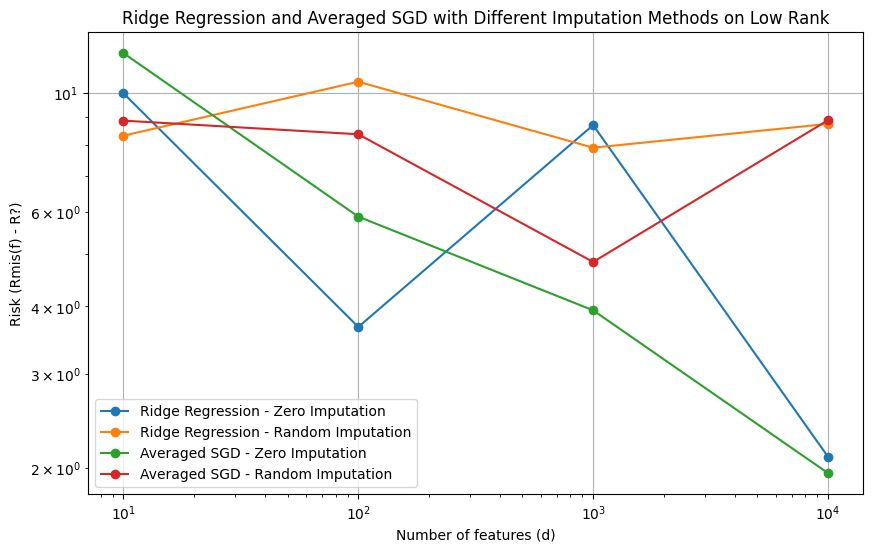

In [5]:
# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(list(ridge_risk_results_constant.keys()),
         list(ridge_risk_results_constant.values()),
         marker='o', label='Ridge Regression - Zero Imputation')


plt.plot(list(ridge_risk_results_random.keys()),
         list(ridge_risk_results_random.values()),
         marker='o', label='Ridge Regression - Random Imputation')

# Plot Averaged SGD risk
plt.plot(list(sgd_risk_results_constant.keys()),
         list(sgd_risk_results_constant.values()),
         marker='o', label='Averaged SGD - Zero Imputation')


plt.plot(list(sgd_risk_results_random.keys()),
         list(sgd_risk_results_random.values()),
         marker='o', label='Averaged SGD - Random Imputation')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of features (d)')
plt.ylabel('Risk (Rmis(f) - R?)')
plt.title('Ridge Regression and Averaged SGD with Different Imputation Methods on Low Rank')
plt.grid(True)
plt.legend()
plt.show()


In [6]:
def generate_spiked_data(n_samples, n_features, rank, noise_std=2, spike_std=0.2):
    # low-rank data
    X_low_rank, Y_low_rank = generate_low_rank_data(n_samples, n_features // 2, rank, noise_std)

    #second set of features with low-rank
    Z = np.random.normal(0, 1, size=(n_samples, rank))
    A2 = np.random.randn(n_features // 2, rank)
    X2 = A2.dot(Z.T).T

    # spiked response using the second set of features
    theta_spiked = np.random.normal(0, spike_std, size=n_features // 2)
    Y2 = X2.dot(theta_spiked)

    # Concatenate the low-rank features and spiked features
    X = np.concatenate([X_low_rank, X2], axis=1)
    Y = Y_low_rank + Y2

    return X, Y


In [9]:
# Run the experiment for constant (zero) imputation
ridge_risk_results_constant = {}
sgd_risk_results_constant = {}

for n_features in n_features_range:
    # Generate and split data
    X, Y = generate_spiked_data(n_samples, n_features, rank, noise_std)
    X_missing = introduce_missingness(X)

    # Impute missing values with constant strategy (zero imputation)
    X_imputed = impute_values(X_missing, strategy='constant')

    # Train-test split
    X_train, X_test, Y_train, Y_test = train_test_split(X_imputed, Y, test_size=0.2, random_state=42)

    # Scale the features
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Ridge Regression
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train_scaled, Y_train)
    ridge_predictions = ridge.predict(X_test_scaled)
    ridge_risk = calculate_risk(Y_test, ridge_predictions)
    ridge_risk_results_constant[n_features] = ridge_risk

    # Averaged SGD
    theta_estimated = averaged_sgd(X_train_scaled, Y_train, gamma, n_epochs=10000)
    sgd_predictions = X_test_scaled.dot(theta_estimated)
    sgd_risk = calculate_risk(Y_test, sgd_predictions)
    sgd_risk_results_constant[n_features] = sgd_risk


In [12]:
# Update plotting section
ridge_risk_results_random = {}
sgd_risk_results_random = {}

# Generate a single random value within the range 10 to 10000
random_value = np.random.randint(1, 501)

for n_features in n_features_range:
    # Call low rank function
    X, Y = generate_spiked_data(n_samples, n_features, rank, noise_std)
    # Call function to impute MCAR
    X_missing = introduce_missingness(X)

    # Impute using Random with range (-1, 1)
    X_imputed = impute_values(X_missing, strategy='random', random_range=(1, 501))

    # Train-test split
    X_train, X_test, Y_train, Y_test = train_test_split(X_imputed, Y, test_size=0.2, random_state=42)

    # Scale the features
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Ridge Regression
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train_scaled, Y_train)
    ridge_predictions = ridge.predict(X_test_scaled)
    ridge_risk = calculate_risk(Y_test, ridge_predictions)
    ridge_risk_results_random[n_features] = ridge_risk

    # Averaged SGD
    theta_estimated = averaged_sgd(X_train_scaled, Y_train, gamma, n_epochs=10000)
    sgd_predictions = X_test_scaled.dot(theta_estimated)
    sgd_risk = calculate_risk(Y_test, sgd_predictions)
    sgd_risk_results_random[n_features] = sgd_risk

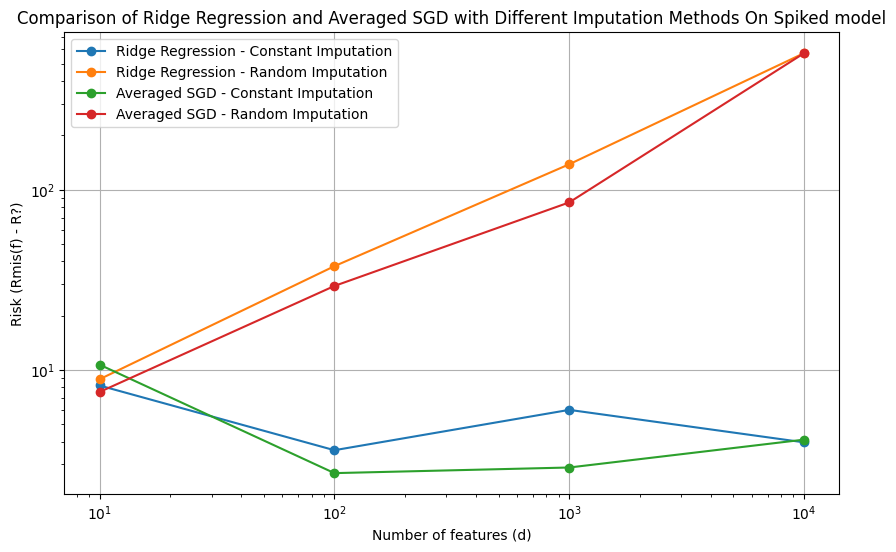

In [13]:

# Plot the results
plt.figure(figsize=(10, 6))

# Plot Ridge Regression risk
plt.plot(list(ridge_risk_results_constant.keys()),
         list(ridge_risk_results_constant.values()),
         marker='o', label='Ridge Regression - Constant Imputation')

plt.plot(list(ridge_risk_results_random.keys()),
         list(ridge_risk_results_random.values()),
         marker='o', label='Ridge Regression - Random Imputation')



# Plot Averaged SGD risk
plt.plot(list(sgd_risk_results_constant.keys()),
         list(sgd_risk_results_constant.values()),
         marker='o', label='Averaged SGD - Constant Imputation')

plt.plot(list(sgd_risk_results_random.keys()),
         list(sgd_risk_results_random.values()),
         marker='o', label='Averaged SGD - Random Imputation')


plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of features (d)')
plt.ylabel('Risk (Rmis(f) - R?)')
plt.title('Comparison of Ridge Regression and Averaged SGD with Different Imputation Methods On Spiked model')
plt.grid(True)
plt.legend()
plt.show()
